# Introduction to the BART Toolbox

This tutorial introduces the BART command-line inteface (CLI).

**Authors**: [Martin Uecker](mailto:uecker@tugraz.at)$^{\dagger,*,+}$, [Nick Scholand](mailto:scholand@tugraz.at)$^{\dagger,*,+}$, [Moritz Blumenthal](mailto:moritz.blumenthal@med.uni-goettingen.de)$^*$, [Xiaoqing Wang](mailto:xiaoqing.wang@med.uni-goettingen.de)$^{\dagger,*,+}$

**Presenter**: [Martin Uecker](mailto:uecker@tugraz.at)

**Institutions**: $^{\dagger}$University of Technology Graz, $^*$University Medical Center Göttingen, $^+$German Centre for Cardiovascular Research  Partnerside Göttingen

## Requirements




### Local Usage
- Install bart from its [github repository](https://github.com/mrirecon/bart) (needed for machine learning part!)
- Set the `TOOLBOX_PATH` to the BART directory and add it to the `PATH`

```bash
export TOOLBOX_PATH=/path/to/bart  
export PATH=$TOOLBOX_PATH:$PATH
```

Although the simplest way to call the BART CLI tools is through a terminal, there are also wrapper functions that allow the tools to run through Matlab and Python. These are located under the `$TOOLBOX_PATH/matlab` and `$TOOLBOX_PATH/python` directories.

### Online Usage
MyBinder and Google Colaboratory allow us to run a Jupyter instance through a browser. In the following we install and configure BART for both instances.

#### Check for GPU

**Google Colaboratory** allows to use a GPU. To access it set:

- Go to Edit → Notebook Settings
- choose GPU from Hardware Accelerator drop-down menu

**MyBinder** does not allow GPU access. The following code will automatically detect which service you are using.

In [1]:
# Check if notebook runs on colab
import sys, os

os.environ['COLAB'] = 'true' if ('google.colab' in sys.modules) else 'false'

# FIXME: Colab without GPU not supported yet
os.environ['CUDA'] = '1' if ('google.colab' in sys.modules) else '0'

In [2]:
%%bash

# Prepare GPUs if on Google Colab

if $COLAB;
then

    # Use CUDA 10.1 when on Tesla K80

    # Estimate GPU Type
    GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

    echo "GPU Type:"
    echo $GPU_NAME

    if [ "Tesla K80" = "$GPU_NAME" ];
    then
        echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

        # Change default CUDA to version 10.1
        cd /usr/local
        rm cuda
        ln -s cuda-10.1 cuda
    else
        echo "Current GPU supports default CUDA-11."
        echo "No further actions are necessary."
    fi

    echo "GPU Information:"
    nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
    nvcc --version
fi

GPU Type:
Tesla K80
GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1.
GPU Information:
name, driver_version, memory.total [MiB]
Tesla K80, 460.32.03, 11441 MiB
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


#### Install BART

Here we install BARTs dependencies, we download the current repository from github and compile it.

In [3]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

In [4]:
%%bash

# Choose a branch to work on
BRANCH=master

cd bart

# Switch to desired branch of the BART project
git checkout $BRANCH

# Define specifications 
COMPILE_SPECS=" PARALLEL=1
                CUDA=$CUDA
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64
                OPENBLAS=1
                BLAS_THREADSAFE=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

# Compile BART
make &> /dev/null

Your branch is up to date with 'origin/master'.


Already on 'master'


After downloading and compiling BART, we set the required `TOOLBOX_PATH` variable pointing to the BART instance:

In [5]:
%env TOOLBOX_PATH=bart

env: TOOLBOX_PATH=bart


#### Set Environment for BART

After downloading and compiling BART, the next step simplifies the handling of BARTs command line interface inside of a ipyhton jupyter-notebook. We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [6]:
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python/")

Check BART setup:

In [7]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
bart/bart
# BART version: 
v0.7.00-315-g6646e06


### Visualization Helper

For this tutorial we will visualize some maps. Therefore, we need a little helper function and some python libraries.


In [8]:
# More python libraries
import cfl
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image

def plot_map(dataname, colorbar, vmin, vmax, cbar_label):

    # Import data        
    data = np.abs(cfl.readcfl(dataname).squeeze())

    # Import colorbar type
    colorbartype =  colorbar

    # Set zero to a black color for a masking effect
    my_cmap = cm.get_cmap(colorbartype, 256)
    my_cmap.set_bad('black')

    data = np.ma.masked_equal(data, 0)

    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(111)
    im = ax1.imshow(data, interpolation='nearest', cmap=my_cmap, vmin=vmin, vmax=vmax)

    # Style settings
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(cbar_label)
    cbar.ax.tick_params()

    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.xaxis.set_ticks_position('none')
    ax1.yaxis.set_ticks_position('none')
    ax1.set_axis_off()

    plt.show()

### Download Supporting Materials
For this tutorial, we also need several supporting materials (figures, plotting scripts and compressed data for ML part). They are stored in the GitHub repository and need to be downloaded.

In [30]:
%%bash

# Download the required supporting material if it is not already there
[ ! -f data.zip ] && wget -q https://github.com/scholand/bart-workshop/raw/test/mri_together_2021/data.zip
unzip -n data.zip

# Download Raw Data for IR FLASH parts
name=IR-FLASH

if [[ ! -f ${name} ]]; then
  echo Downloading ${name}
  wget -q https://zenodo.org/record/4060287/files/${name}.cfl
  wget -q https://zenodo.org/record/4060287/files/${name}.hdr

  mv ${name}.cfl data/${name}.cfl
  mv ${name}.hdr data/${name}.hdr
fi

head -n2 data/${name}.hdr

Archive:  data.zip
# Dimensions
512 1 1 16 1 1 1 1 1 1 1020 1 1 1 1 1 


## BARTs Command Line Tool
BART provides a number of tools for MRI image reconstruction and multi-dimensional array manipulation.

In [32]:
# get a list of BART commands by running bart with no arguments:
! bart

BART. Available commands are:
avg         bench       bin         bitmask     cabs        caldir      
calmat      carg        casorati    cc          ccapply     cdf97       
circshift   conj        conv        conway      copy        cpyphs      
creal       crop        delta       ecalib      ecaltwo     epg         
estdelay    estdims     estshift    estvar      extract     fakeksp     
fft         fftmod      fftrot      fftshift    filter      flatten     
flip        fmac        homodyne    index       invert      itsense     
join        looklocker  lrmatrix    mandelbrot  mip         moba        
mobafit     multicfl    nlinv       nnet        noise       normalize   
nrmse       nufft       onehotenc   ones        pattern     phantom     
pics        pocsense    poisson     pol2mask    poly        reconet     
repmat      reshape     resize      rmfreq      rof         roistat     
rss         rtnlinv     sake        saxpy       scale       sdot        
show        signal   

### BART Command Structure

The command structure follows

> **`bart`** + **`command`** + **`options`** + **`input / output`**

Each BART command comtains a number of optional arguments, followed by input and output files.   
To see all options and requirements of a command, use the `-h` flag:


In [33]:
# Obtain help for each command (-h)
! bart toimg -h

Usage: toimg [-g f] [-c f] [-w f] [-d] [-m] [-W] <input> <output prefix> 

Create magnitude images as png or proto-dicom.
The first two non-singleton dimensions will
be used for the image, and the other dimensions
will be looped over.

-g gamma       gamma level
-c contrast    contrast level
-w window      window level
-d             write to dicom format (deprecated, use extension .dcm)
-m             re-scale each image
-W             use dynamic windowing
-h             help


BART loosely follows the Linux CLI convention, where optional arguments are indicated with brackets, and files are indicated by carrot symbols.

As we can see, there are many CLI tools available. The full descriptions of each program can be found under `$TOOLBOX_PATH/doc/commands.txt`.

### Using BART
 
As a first example, let's create a Shepp-Logan numerical phantom in k-space. We will use the `phantom` tool. Before using the tool, let's look at its options

In [34]:
! bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <file>] [-G] [-T] [-N d] [-B] [-x d] [-g d] [-3] [-b] [-r d] <output> 

Image and k-space domain phantoms.

-s nc       nc sensitivities
-S nc       Output nc sensitivities
-k          k-space
-t file     trajectory
-G          geometric object phantom
-T          tubes phantom
-N num      Random tubes phantom and number
-B          BART logo
-x n        dimensions in y and z
-g n=1,2    select geometry for object phantom
-3          3D
-b          basis functions for geometry
-r seed     random seed initialization
-h          help


The `phantom` tool includes the option `-k` to create it directly in k-space, and `-x` to specify the dimensions.

Shepp-Logan k-space phantom


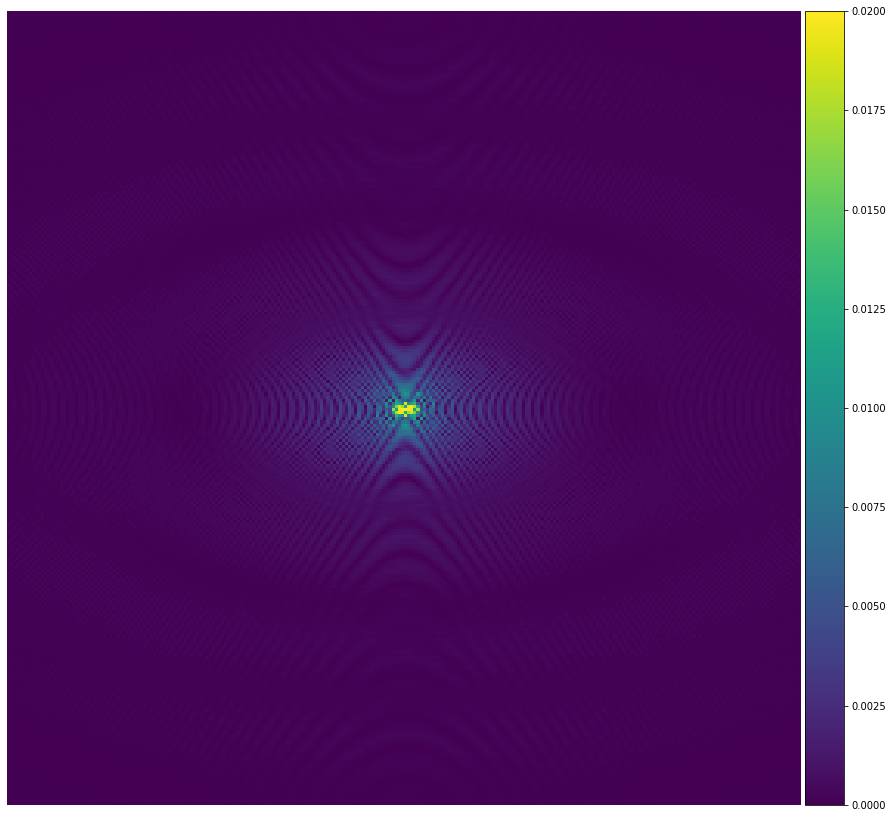

In [35]:
# Create Cartesian k-space phantom (256 samples)
! bart phantom -x 256 -k shepp_logan

! echo "Shepp-Logan k-space phantom"
plot_map("shepp_logan", "viridis", 0, 0.02, '')

### Data File Format
All data files are multi-dimensional arrays. By running the `phantom` command, we made new files on disk, with the names  
`shepp_logan.cfl` and `shepp_logan.hdr`

The data files represent a multi-dimensional array. The `hdr`, or header file, contains the data dimensions and other information about the dataset. The `cfl`, or complex-float file, contains the single-precision raw data in column-major order and interleaved real and imaginary parts.  

The header file is a raw text file and can be opened with any text editor. The complex-float file is a binary file. Matlab and Python readers/writers are available under the `matlab` and `python` directories, respectively.

### View data dimensions
Because the header file is a text file, we can directly print it:

In [36]:
! cat shepp_logan.hdr

# Dimensions
256 256 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
# Command
phantom -x 256 -k shepp_logan 
# Files
 >shepp_logan
# Creator
BART v0.7.00-315-g6646e06


Although not discussed here, BART can write to other file formats, including a simple H5 container, ISMRMRD format, and others. Therefore, not every format will include a header file. Thus, it is better to use the `show` command.

In [37]:
! bart show -h

Usage: show [-m] [-d d] [-s <string>] [-f <string>] <input> 

Outputs values or meta data.

-m           show meta data
-d dim       show size of dimension
-s sep       use <sep> as the separator
-f format    use <format> as the format. Default: "%%+.6e%%+.6ei"
-h           help


We can look at an individual dimension of the data with the `-d` command, or we can display all the meta data about the dataset. 

Next, we show the dimensions of the created Shepp-Logan phantom

In [38]:
! bart show -m shepp_logan

Type: complex float
Dimensions: 16
AoD:	256	256	1	1	1	1	1	1	1	1	1	1	1	1	1	1


Our dataset is 16-dimensional, but only the first two dimensions are non-singleton.

By convention, the dimensions are `[X, Y, Z, C, M, T, F, ...]`,
where `(X, Y, Z)` are the spatial matrix dimensions,  
`C` and `M` are the coil dimensions and ESPIRiT maps dimensions, respectively,  
`T` and `F` are used for echo times and coefficient dimensions,   
and other higher order dimensions such as phase, flow encode, etc.

### Using Bitmasks
Let's reconstruct our k-space phantom. using a simple inverse Fourier transform.  
Therefore, we perform a Fast Fourier Transform (FFT).

BART has an `fft` tool for doing just that.

IFFT of Shepp-Logan phantom


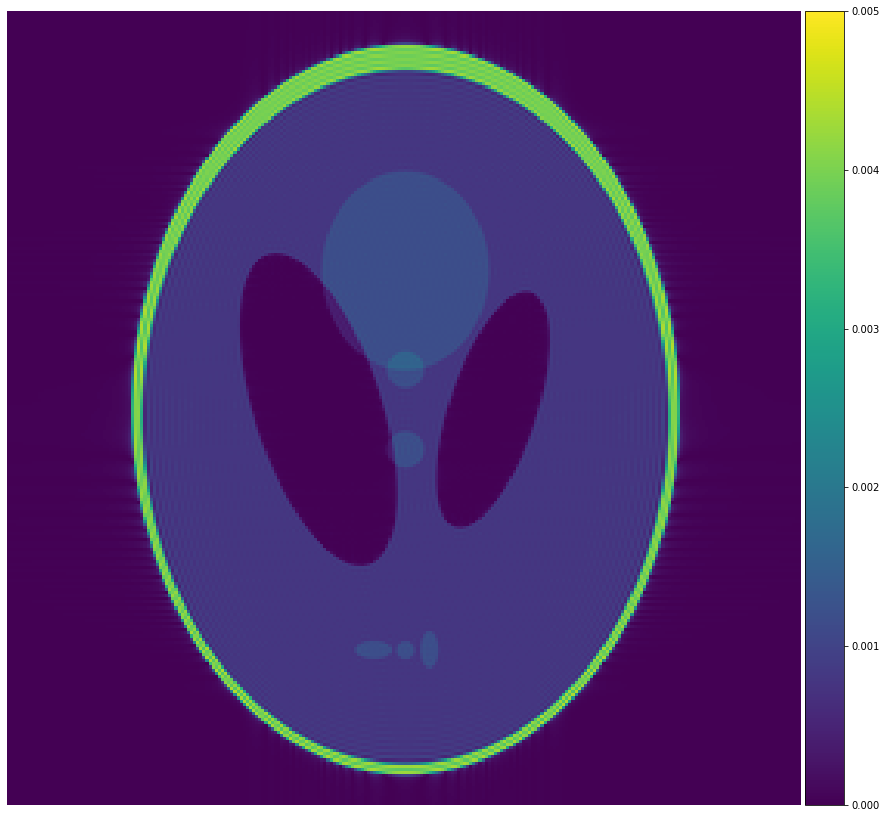

In [39]:
# Perform FFT reconstruction
! bart fft -u -i 3 shepp_logan shepp_logan_rec

! echo "IFFT of Shepp-Logan phantom"
plot_map("shepp_logan_rec", "viridis", 0, 0.005, '')

Let's see the fft-options.

In [40]:
# Show help for fft command
! bart fft -h

Usage: fft [-u] [-i] [-n] bitmask <input> <output> 

Performs a fast Fourier transform (FFT) along selected dimensions.

-u    unitary
-i    inverse
-n    un-centered
-h    help


Thus, we performed an inverse (`-i`) unitary (`-u`) Fast Fourier Transform on the image dimensions **`(0, 1)`** specified by the bitmask **`3`**.


Instead of using for loops, BART data operates on bitmasks. To operate on a particular array dimension, a bitmask specifies the active dimensions. This is a powerful approach for perfoming multi-dimensional operations, as all the tools will work on arbitrarily chosen dimensions.   

In our case, we wanted to perform an IFFT along dimensions 0 and 1, and the bitmask is calculated as:  
<center>
$ \text{bitmask}=2^{~0} + 2^{~1} = 3$
</center> <br>
BART also provides a command-line tool to calculate the bitmasks for specific dimensions.

In [41]:
# Calculate bitmask for active dimensions 0 and 1
! bart bitmask 0 1

3


## BART Examples


### Subspace T1 Mapping

A specialized tutorial for subspace T1 mapping with BART can be found in the [3rd BART Webinar Materials](https://github.com/mrirecon/bart-webinars/tree/master/webinar3).

We start by importing the characteristics of the downloaded IR-FLASH dataset following BARTs dimensionality definitions.

In [42]:
dim = np.shape(cfl.readcfl("data/IR-FLASH"))

os.environ['READ'] = str(dim[0])
os.environ['SPOKES'] = str(dim[2])
os.environ['COILS'] = str(dim[3])
os.environ['REP'] = str(dim[10])

Set the known sequence information.

In [43]:
%env TR=0.0041

env: TR=0.0041


#### Dictionary Generation, SVD and Temporal Basis

Set the number of temporal subspace coefficients.

In [44]:
%env NUM_COE=4

env: NUM_COE=4


Now we have everything to generate the dictionary

In [45]:
%%bash


# Dictionary characteristics
## R1s
NUM_R1S=1000
MIN_R1S=5e-3
MAX_R1S=5

## Mss
NUM_MSS=100
MIN_MSS=1e-2
MAX_MSS=1

# Simulate dictionary based on the `signal` tool
bart signal -F -I -n$REP -r$TR \
            -1 $MIN_R1S:$MAX_R1S:$NUM_R1S \
            -3 $MIN_MSS:$MAX_MSS:$NUM_MSS  dicc

# reshape the dicc 6th and 7th dimension to have all the elements 
# concentrated in the 6th dimension
bart reshape $(bart bitmask 6 7) $((NUM_R1S * NUM_MSS)) 1 dicc dicc_reshape

# squeeze the reshaped dictionary to remove non-zero dimensions
bart squeeze dicc_reshape dicc_squeeze

And perform an svd to create our temporal basis

In [46]:
%%bash

# Perform an SVD of the squeezed dictionary and output and
# economy-size decomposition of the resulting matrix
bart svd -e dicc_squeeze U S V

# Extract desired number of orthonormal columns from U
bart extract 1 0 $NUM_COE U basis0

# transpose the basis to have time in the 5th dimension 
# and coefficients in the 6th dimension
bart transpose 1 6 basis0 basis1
bart transpose 0 5 basis1 basis

# Print the transposed basis dimensions
echo "Temporal Basis"
head -n2 basis.hdr

Temporal Basis
# Dimensions
1 1 1 1 1 1020 4 1 1 1 1 1 1 1 1 1 


#### Coil Compression
To reduce the size of our dataset and therefore also decrease the computational complexity, we perform a coil compression with the `cc` command. By passing `-A` we choose to use all possible data and want to reduce the dataset to *NUM_VCOILS* virtual coils with `-p` to


In [47]:
%env NUM_VCOILS=8

env: NUM_VCOILS=8


In [48]:
%%bash

# Transpose the 0th and 1st dimension of the downloaded data
# to ensure compatibility with BARTs non-Cartesian tools
bart transpose 0 1 data/IR-FLASH ksp

# Perform coil compression
bart cc -A -p $NUM_VCOILS ksp ksp_cc

Done.


#### Trajectory Generation
In the next step we generate a trajectory with the `traj` tool. To match the acquisition of the downloaded data, we need to specify a radial `-r`, centered `-c`, double-angle `-D`, 7th tiny golden-angle `-G -s7` sampling. 

In [50]:
%env NUM_TGA=7

env: NUM_TGA=7


The timesteps are passed using `-t`, the spokes by `-y` and the samples are specified with `-x`.

In [51]:
%%bash

# Read file characteristics from downloaded dataset
READ=`bart show -d 0 data/IR-FLASH`
SPOKES=`bart show -d 2 data/IR-FLASH`
REP=`bart show -d 10 data/IR-FLASH`

# Create the trajectory using the `traj` tool
bart traj -r -c -D -G -x$READ -y$SPOKES -s$NUM_TGA -t$REP traj

# Print out its dimensions
echo "Trajectory"
head -n2 traj.hdr

Trajectory
# Dimensions
3 512 1 1 1 1 1 1 1 1 1020 1 1 1 1 1 


Here the 3 in the zeroth dimensions includes the coordinates in (x,y,z) and is the reasion for the previous transpose of the downloaded dataset!

#### Gradient Delay Correction
Because the dataset is following an IR FLASH signal relaxation, the gradient delay correction should be applied to data in the last repetitions which are in a steady-state. Therefore, we extract some final repetitions from the trajectory and the dataset using the `extract` command. Have in mind that the time dimension is the 10th here!

In [52]:
%%bash

# Define the number of timesteps the gradient delay correction should be 
# performed on (Steady-State)
FRAMES_FOR_GDC=100

# Extract the DATA_GDC last time frames from the trajectory and the dataset
bart extract 10 $((REP-FRAMES_FOR_GDC)) $REP traj traj_extract
bart extract 10 $((REP-FRAMES_FOR_GDC)) $REP ksp_cc ksp_extract

# Transpose the 2nd and 10th dimension for later use with the `estdelay` tool
bart transpose 10 2 traj_extract traj_extract1
bart transpose 10 2 ksp_extract ksp_extract1

# Estimate and store the gradient delays usign RING
GDELAY=$(bart estdelay -R traj_extract1 ksp_extract1)

echo "Gradient Delays: "$GDELAY

# Calculate the trajectory with known gradient delays
bart traj -r -c -D -G -x$READ -y$SPOKES -s$NUM_TGA -t$REP -q $GDELAY trajn

Gradient Delays: -0.120593:0.161684:0.009525


#### Coil Sensitivity Estimation

The coil profile estimation is similar to the gradient delay estimation performed on some of the last timesteps of the IR FLASH dataset. Therefore, *FRAMES_FOR_CSE* spokes from the last timesteps are extracted using the `extract` command.

In [53]:
%%bash

# Define the number of timesteps at th end of the dataset, where the coil 
# sensitivity estimation should be performed on (Steady-State)
FRAMES_FOR_CSE=300

# Extract last time frames (10th dim) from trajectory and k-space data
bart extract 10 $((REP-FRAMES_FOR_CSE)) $REP trajn traj_ss
bart extract 10 $((REP-FRAMES_FOR_CSE)) $REP ksp_cc ksp_cc_ss

bart transpose 2 10 traj_ss traj_ss2
bart transpose 2 10 ksp_cc_ss ksp_cc_ss2

# apply an inverse nufft of the extracted steady-state dataset
bart nufft -i -d$READ:$READ:1 traj_ss2 ksp_cc_ss2 img

# transform reconstruction in image space back to k-space
# to create gridded k-space for the ESPIRiT implementation
bart fft -u $(bart bitmask 0 1 2) img ksp_grid

THRESHOLD=0.01
NUM_ESPIRIT_MAP=1

# Estimate coil sensitivities from gridded, steady-state k-space using `ecalib`
bart ecalib -S -t $THRESHOLD -m $NUM_ESPIRIT_MAP ksp_grid sens_invivo


Done.
Done.


In [58]:
!cat sens_invivo.hdr

# Dimensions
512 512 1 8 1 1 1 1 1 1 1 1 1 1 1 1 
# Command
ecalib -S -t 0.01 -m 1 ksp_grid sens_invivo 
# Files
 >sens_invivo <ksp_grid
# Creator
BART v0.7.00-315-g6646e06


In-Vivo Sensitivity Maps


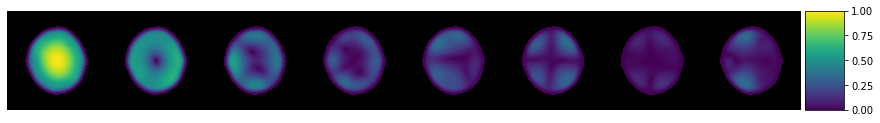

In [61]:
# Reshape and flip coefficient maps for improved visualization

## Concentrate all coefficients in the column dimension (1st/phase1)
! bart reshape $(bart bitmask 1 3) $((READ*NUM_VCOILS)) 1 sens_invivo sens_invivo_lin

## Flip the map in row dimension to have the forhead pointing to the top of the page
! bart flip $(bart bitmask 0) sens_invivo_lin sens_invivo_flip

! echo "In-Vivo Sensitivity Maps"
plot_map("sens_invivo_flip", "viridis", 0, 1, '')

#### Subspace-Constrained Reconstruction
To start the subspace-constrained reconstruction we need to verify the data and trajectory dimension again.

In [54]:
%%bash

# Transpose dimensions for working with PICS tool
bart transpose 5 10 trajn traj_final
bart transpose 5 10 ksp_cc ksp_final

DEBUG=4
ITER=100
REG=0.0015

[ $CUDA ] && GPU=-g

bart pics   $GPU -e -d $DEBUG -i$ITER \
            -RW:$(bart bitmask 0 1):$(bart bitmask 6):$REG \
            -t traj_final -B basis \
            ksp_final sens_invivo subspace_reco_invivo

# Print dimensions of reconstruction
echo "Reconstructed Coefficient"
head -n2 subspace_reco_invivo.hdr

# Resize reconstructions to remove 2-fold oversampling effects
bart resize -c 0 $((READ/2)) 1 $((READ/2)) subspace_reco_invivo coeff_maps

Basis: [512 512   1   8   1 1020   4   1   1   1   1   1   1   1   1   1 ]
Max:   [512 512   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
GPU reconstruction
[  1 512   1   8   1 1020   4   1   1   1   1   1   1   1   1   1 ]
[512 512   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512   1   8   1 1020   4   1   1   1   1   1   1   1   1   1 ]
cim : [512 512   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512   1   1   1 1020   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512   1   1   1 1020   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 1020   4   1   1   1   1   1   1   1   1   1 ]
[  1   1   1   1   1 1020   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 512   1   1   1   4   4   1   1   1   1   1   1   1   1   1   1 1020 ]
nufft psf dims:    [1024 1024   1   1   1   4   4   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512   1   1   1   1   1 

#### Visualization of Reconstructed Maps

Subspace Coefficient Maps


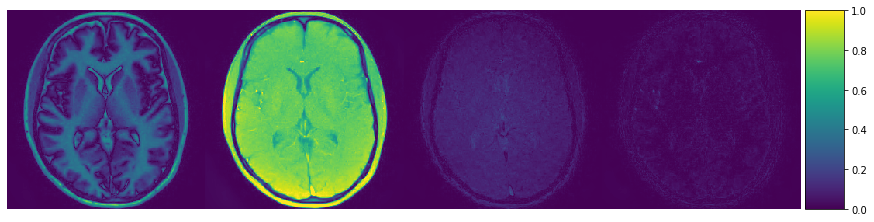

In [55]:
# Reshape and flip coefficient maps for improved visualization

## Concentrate all coefficients in the column dimension (1st/phase1)
! bart reshape $(bart bitmask 1 6) $((READ/2*NUM_COE)) 1 coeff_maps subspace_maps

## Flip the map in row dimension to have the forhead pointing to the top of the page
! bart flip $(bart bitmask 0) subspace_maps subspace_maps1

! echo "Subspace Coefficient Maps"
plot_map("subspace_maps1", "viridis", 0, 1, '')

### Model-Based T1 Mapping

A specialized tutorial for model-based reconstructions in BART can be found in the [Workshop Material of the ISMRM 2021](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021).

#### Theory

**Single-Shot Inversion-Prepared T1 Mapping**

<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/model_based/IR_FLASH.png?raw=1" style="width: 550px;">


**General Idea of Model-based Reconstruction**:
> Formulate the estimation of MR physical parameters directly from k-space as a nonlinear inverse problem.





**Operator chain of parallel imaging and signal model (nonlinear)**

<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/model_based/operator_chain.png?raw=1" style="width: 400px;">

$$F: x \mapsto y = {\mathcal{P} \mathcal{F} C} \cdot {M(x_{p})}$$
- $\mathcal{P}$ - sampling pattern
- $\mathcal{F}$ - Fourier transform
- $C$ - coil sensitivity maps
- $M(\cdot)$ - MR physics model
- $x_{p}$ - MR parameters
- $y$ - acquired kspace data

#### Optimization

We use the iteratively regularized Gauss-Newton method (IRGNM) in BART to solve the nonlinear inverse problem

$$\hat{x} = \text{argmin}_{x}\|F(x) -y\|_{2}^{2} + \lambda \cdot R(x), $$

i.e., the nonlinear problem can be linearly solved in each Gauss-Newton step:

$$\hat{x}_{n+1}= \text{argmin}_{x}\|DF(x_{n})(x−x_{n}) +F(x_{n})−y\|_{2}^{2} + \lambda \cdot R(x)$$

$DF(x_{n})$ is the Jacobian matrix of $F$ at the point $x_{n}$ of the $n$th Newton step.

---

Therefore, we can directly estimate the MR parameter maps from undersampled k-space datasets. No pixel-wise fitting or intermediate reconstruction of contrast-weighted images is required!

For further information have a look into:

> [Wang X](mailto:xiaoqing.wang@med.uni-goettingen.de), Roeloffs V, Klosowski J, Tan Z, Voit D, Uecker M, Frahm J.,  
[Model-based T1 Mapping with Sparsity Constraints Using Single-Shot Inversion-Recovery Radial FLASH](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.26726).  
Magn Reson Med 2018;79:730-740.

In [49]:
! bart moba -h

Usage: moba [-r ...] [-L] [-F] [-G] [-m d] [-l d] [-i d] [-R f] [-T f] [-j f] [-u f] [-C d] [-s f] [-B f] [-b f:f] [-d d] [-f f] [-p <file>] [-J] [-M] [-g] [-I <file>] [-t <file>] [-o f] [-k] [--kfilter-1] [--kfilter-2] [-n] [--fat_spec_0] <kspace> <TI/TE> <output> [<sensitivities>] 

Model-based nonlinear inverse reconstruction

-r <T>:A:B:C    generalized regularization options (-rh for help)
-L              T1 mapping using model-based look-locker
-F              T2 mapping using model-based Fast Spin Echo
-G              T2* mapping using model-based multiple gradient echo
-m model        Select the MGRE model from enum { WF = 0, WFR2S, WF2R2S, R2S, PHASEDIFF } [default: WFR2S]
-l 1/-l2         toggle l1-wavelet or l2 regularization.
-i iter         Number of Newton steps
-R redu         reduction factor
-T damp         damping on temporal frames
-j minreg       Minimum regu. parameter
-u rho          ADMM rho [default: 0.01]
-C iter         inner iterations
-s step         step s

The data preparation is dicussed in detail in the [3rd event of the BART webinar series](https://github.com/mrirecon/bart-webinars/tree/master/webinar3). Here you can find presentation and exercise materials for the individual steps

* Download raw data  
* Coil compression  
* Prepare radial trajectory (golden-angle) including gradient-delay correction  
* Prepare time vector

which are not mentioned in detail here.



#### Dimensions

The dataset is the used inthe subspace tutorial above. Therefore, the global variables (READ, SPOKES,...) defining its dimensions do not have to be changed.

#### Coil Compression

We will compress our dataset to

In [ ]:
%env NUM_VCOILS=3

env: NUM_VCOILS=3


coils. This is for the purpose of fast computation, for a better performance, 8 or 10 are recommended.

In [ ]:
%%bash

## Coil compression
bart transpose 0 1 data/IR-FLASH ksp

# coil compression
bart cc -A -p $NUM_VCOILS ksp ksp_cc

Done.


#### Trajectory Preparation with Gradient Delay Correction

In [ ]:
%%bash

## Prepare radial trajectory (golden-angle)
bart traj -r -c -D -G -x$READ -y$SPOKES -s7 -t$REP traj

# Gradient Delay Correction
# Extract the steady-state data (data with less contrast change)
bart extract 10 920 1020 traj traj_extract
bart extract 10 920 1020 ksp_cc ksp_extract

# Transpose the 2nd and 10th dimension for the `estdelay` tool
bart transpose 10 2 traj_extract traj_extract1
bart transpose 10 2 ksp_extract ksp_extract1

# Gradient delay estimation usign RING
GDELAY=$(bart estdelay -R traj_extract1 ksp_extract1)

echo "Gradient Delays: "$GDELAY

# Calculate the "correct" trajectory with known gradient delays
bart traj -r -c -D -G -x$READ -y$SPOKES -s7 -t$REP -q $GDELAY trajn

Gradient Delays: -0.120477:0.166771:0.008643


#### Preparation of Time Vector

In [ ]:
%%bash

## Prepare time vector
TR=4100 #TR in [us]
BIN_SPOKES=20 # Bin data to save computational time 

NTIME=$((REP/BIN_SPOKES)) # Integer division!

# Create vector from 0 to NTIME
bart index 5 $NTIME tmp1
# use local index from newer bart with older bart
bart scale $(($BIN_SPOKES * $TR)) tmp1 tmp2
bart ones 6 1 1 1 1 1 $NTIME tmp1 
bart saxpy $((($BIN_SPOKES / 2) * $TR)) tmp1 tmp2 tmp3
bart scale 0.000001 tmp3 TI

# Reshape trajectory and data for model-based reconstruction
bart reshape $(bart bitmask 2 5 10) $BIN_SPOKES $NTIME 1 trajn traj_moba
bart reshape $(bart bitmask 2 5 10) $BIN_SPOKES $NTIME 1 ksp_cc ksp_cc_moba

# Resize data and trajectory for faster computation
bart resize -c 1 384 traj_moba traj_moba1
bart resize -c 1 384 ksp_cc_moba ksp_cc_moba1

echo "Trajectory:"
head -n2 traj_moba1.hdr

echo "Data:"
head -n2 ksp_cc_moba1.hdr

echo "TI:"
head -n2 TI.hdr''

Trajectory:
# Dimensions
3 384 20 1 1 51 1 1 1 1 1 1 1 1 1 1 
Data:
# Dimensions
1 384 20 3 1 51 1 1 1 1 1 1 1 1 1 1 
TI:
# Dimensions
1 1 1 1 1 51 1 1 1 1 1 1 1 1 1 1 


#### Nonlinear Model-based Reconstruction

The full nonlinear reconstruction can be applied to data by using only the `moba` command in the BART CLI. No coil sensitivity information is necessary, because they are jointly estimated.

A detailed description of the reconstruction can be also found in the [3rd event of the BART webinar series](https://github.com/mrirecon/bart-webinars/tree/master/webinar3).

Here we apply a non-linear inversion-recovery Look-Locker model `-L` to our single-shot data. We also exploit compressed sensing by adding a wavelet $l_1$ regularization with the `-l1` flag.

In [ ]:
%%bash

[ $CUDA ] && GPU=-g

bart moba -L $GPU -d4 -l1 -i8 -C100 -j0.09 -B0.0 -n -t traj_moba1 ksp_cc_moba1 TI reco_moba 

#-L  --- to select look-locker model
#-g  --- to use GPU
#-d  --- debug level
#-l1 --- to use l1-Wavelet regularization
#-i  --- number of Newton-steps
#-C  --- maximum number of inner iterations (FISTA)
#-j  --- minimum regularization parameter
#-B  --- lower bound for relaxivity (R1s > 0)

# NOTE: There is no need of input of coil sensitivity maps, because we jointly estimate coils using model-based reconstruction

nufft kernel dims: [  1 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [480 480   1   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 391680 (vs. 12142080) + 11750400
ksp : [  1 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [480 480   1   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 384  20   3   1  51   1   1   1   1   1   1   1   1   1   1 ]
cim : [480 480   1   3   1  51   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 15409.008528
Scaling_psf: 1.622453
[480 480   1   1   1   1   3   1   1   1   1   1   1   1   1   1 ]
[480 480   1   1   1  51   1   1   1   1   1   1   1   1   1   1 ]
[480 480   1   1   1  51   1   1   1   1   1   1   1   1  

tcmalloc: large alloc 1128038400 bytes == 0x560a0a654000 @  0x7feaf29081e7 0x5609ea1fbfe9 0x5609ea0f6852 0x5609ea10176f 0x5609ea104ddc 0x5609ea0c6dc5 0x5609ea095543 0x5609ea095490 0x7feae1ff1bf7 0x5609ea09525a


#### Visualize Results

To visualize the output of the reconstruction we resize it and thus remove the applied oversampling. Additionally, we slice the individual maps out of its original file and place them next to each other for the final visualization.

Reconstructed Coefficient Maps: Mss, M0, R1s


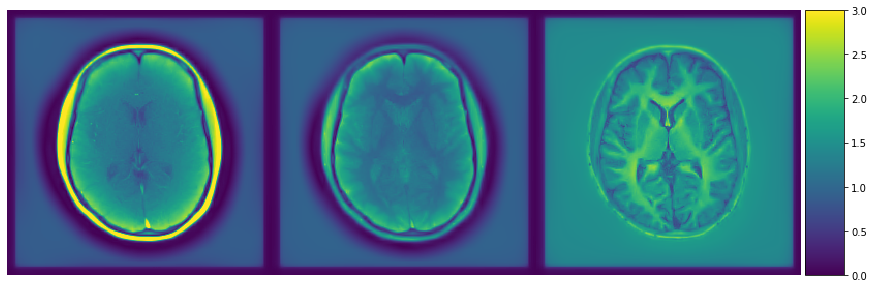

In [ ]:
# Remove oversampling on maps Mss, M0, R1s
! bart resize -c 0 $((READ/2)) 1 $((READ/2)) reco_moba reco_maps

# Concentrate all coefficients in the column dimension for visualization
! bart reshape $(bart bitmask 1 6) $((3*READ/2)) 1 reco_maps reco_maps_lin

# Flip the map in row dimension to have the forhead pointing to the top of the page
! bart flip $(bart bitmask 0) reco_maps_lin reco_maps_flip

! echo "Reconstructed Coefficient Maps: Mss, M0, R1s"
plot_map("reco_maps_flip", "viridis", 0, 3, '')

The output of the nonlinear Look-Locker model-based reconstruction are the parameter maps Mss, M0 and R1*.  
To estimate the desired T1 map we pass the reconstruction results to the `looklocker` command and visualize the T1 map here.

In [ ]:
%%bash

INVERSION_DELAV=0.0153
THRESHOLD=0.2


# use the "looklocker" tool in BART for estimating T1 from the parameters 
# Mss, M0, R1s
bart looklocker -t $THRESHOLD -D $INVERSION_DELAV reco_maps tmp

# Flip the map in row dimension to have the forhead pointing to the top of the page
bart flip $(bart bitmask 0) tmp moba_T1map

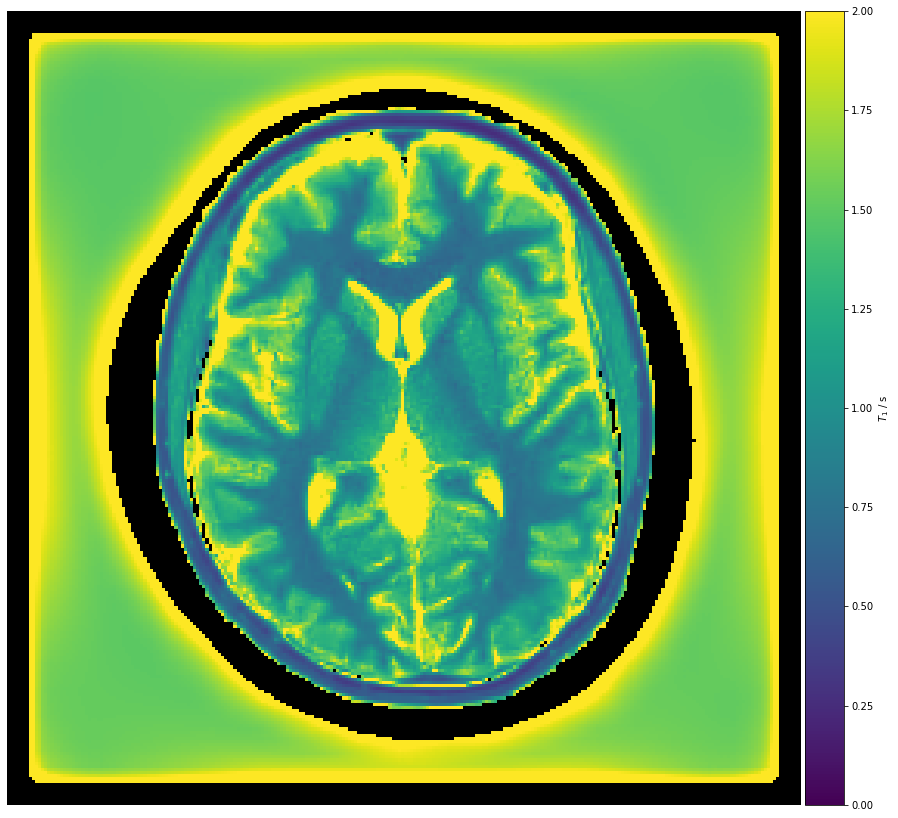

In [ ]:
# python3 save_maps.py moba_T1map viridis 0 2.0 moba_T1map.png
plot_map("moba_T1map", "viridis", 0, 2, '$T_1$ / s')

### BART for Machine Learning - Reconstruction Networks

A specialized tutorial for neural networks in BART can be found in the [Workshop Material of the ISMRM 2021](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021).

#### Theory
We have implemented

> Variational Network<sup>1</sup>:
$$
x^{(i)} = x^{(i-1)}  - \lambda \nabla||Ax -b||^2 + Net(x^{(i-1)}, \Theta^{(i)} )
$$
> MoDL<sup>2</sup>:
$$
\begin{align}
z^{(i)} &= Net\left(x^{(i-1)}, \Theta \right)\\
x^{(i)} &= \mathrm{argmin}_x ||Ax -b||^2 + \lambda ||x - z^{(i)}||^2
\end{align}
$$

>Where
+ $A$ - MRI forward operator $\mathcal{PFC}$
    + $\mathcal{P}$ - Sampling pattern
    + $\mathcal{F}$ - Fourier transform
    + $\mathcal{C}$ - Coil sensitivity maps
+ $b$ - measured k-space data
+ $x^{(i)}$ - reconstruction after $i$ iterations
+ $x^{(0)}=A^Hb$ - initialization
+ $\Theta$ - Weights

>1: Hammernik, K. et al. (2018), [Learning a variational network for reconstruction of accelerated MRI data](https://doi.org/10.1002/mrm.26977). Magn. Reson. Med., 79: 3055-3071.

>2: Aggarwal, H. K. et al.(2019), [MoDL: Model-Based Deep Learning Architecture for Inverse Problems](https://doi.org/10.1109/TMI.2018.2865356). IEEE Trans. Med. Imag., 38(2): 394-405

To **train**, **evaluate** or **apply** unrolled networks, we provide the `bart reconet` command. It follows the same logic as the `bart nnet` command but gets the coil sensitivity maps as an additional input. Let us look at the help:

In [ ]:
! bart reconet -h

Usage: reconet [-t,--train] [-e,--eval] [-a,--apply] [-g,--gpu] [-l,--load <file>] [-b,--batch-size d] [-I,--iterations d] [-n,--normalize] [-N,--network ...] [--resnet-block ...] [--varnet-block ...] [--unet ...] [--data-consistency ...] [--initial-reco ...] [--shared-weights] [--no-shared-weights] [--shared-lambda] [--no-shared-lambda] [--rss-norm] [--trajectory <file>] [--pattern <file>] [--mask <file>] [--valid-data ...] [--train-loss ...] [--valid-loss ...] [-T,--train-algo ...] [--adam ...] [--iPALM ...] [--load-memory] [--lowmem] [--test] [--export-graph <string>] <kspace> <sensitivities> <weights> <ref/out> 

Trains or appplies a neural network for reconstruction.

-t,--train                   train reconet
-e,--eval                    evaluate reconet
-a,--apply                   apply reconet
-g,--gpu                     run on gpu
-l,--load <weights-init>     load weights for continuing training
-b,--batch-size d            size of mini batches
-I,--iterations d            n

In [ ]:
! bart reconet --network h

Usage of sub-option: -N,--network [modl],[varnet]

Sub-options: select neural network

modl      use MoDL Network (also sets train and data-consistency default values)
varnet    use Variational Network (also sets train and data-consistency default values)
h         help


#### Preparation of Knee-Data

Here, we use the data provided with the publication of the Variational Network, i.e. the coronal_pd_fs folder of the NYU-Dataset. The data has been converted to the .cfl-file format.  
In the data folder, we find the fully-sampled kspace data of a knee and a sampling pattern. As the kspace is fully sampled, we can define a ground truth reference.

Before we apply the networks, we will create/estimate:
+ the downsampled kspace
+ coil sensitivity maps
+ a ground truth reference


# K-Space (fully sampled):
# Dimensions
640 368 1 15 1 1 1 1 1 1 1 1 1 1 1 1 

# Pattern:
# Dimensions
640 368 1 1 1 


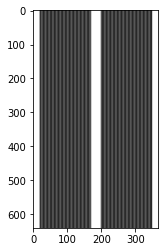

In [17]:
! echo $'\n# K-Space (fully sampled):'
! head -n2 data/kspace_fs.hdr

! echo $'\n# Pattern:'
! head -n2 data/pattern_po_4.hdr

pattern = np.abs(cfl.readcfl("data/pattern_po_4"))
plt.imshow(pattern, cmap="gray")
plt.show()

#### Create Downsampled Kspace

We downsample the fully-sampled kspace by multiplying it with the sampling pattern:

In [18]:
! bart fmac data/kspace_fs data/pattern_po_4 kspace

#### Estimate Coil Sensitivity Maps

We estimate the coil sensitivity maps using ESPIRiT. 

In [19]:
! bart ecalib -r24 -m1 kspace coils_l
! bart resize -c 0 320 coils_l coils

Done.


#### Reconstruction of the Reference

We construct the **ground truth reference** as the coil-combinded reconstruction of the fully-sampled kspace data. For comparison, we also compute a **l1-wavelet** regularized and the **zero-filled** reconstruction.

In [20]:
%%bash

mkdir -p tmp

FFT_FLAG=$(bart bitmask 0 1)
COIL_FLAG=$(bart bitmask 3)

# Reference
bart fft -i -u $FFT_FLAG data/kspace_fs tmp/coil_image
bart fmac -C -s$COIL_FLAG tmp/coil_image coils_l tmp/image

# PICS l1
bart pics -S -l1 -r0.001 -p data/pattern_po_4 kspace coils_l tmp/pics_reco_l

# Zero-filled
bart fft -i -u $FFT_FLAG kspace tmp/coil_image_zf
bart fmac -C -s$COIL_FLAG tmp/coil_image_zf coils_l tmp/image_zf_l

#resize (frequency oversampling)
bart resize -c 0 320 tmp/image ref
bart resize -c 0 320 tmp/pics_reco_l pics_reco
bart resize -c 0 320 tmp/image_zf_l zero_filled

rm -r tmp

Size: 235520 Samples: 90880 Acc: 2.59
l1-wavelet regularization: 0.001000
FISTA
Total Time: 7.617907


We show the results:

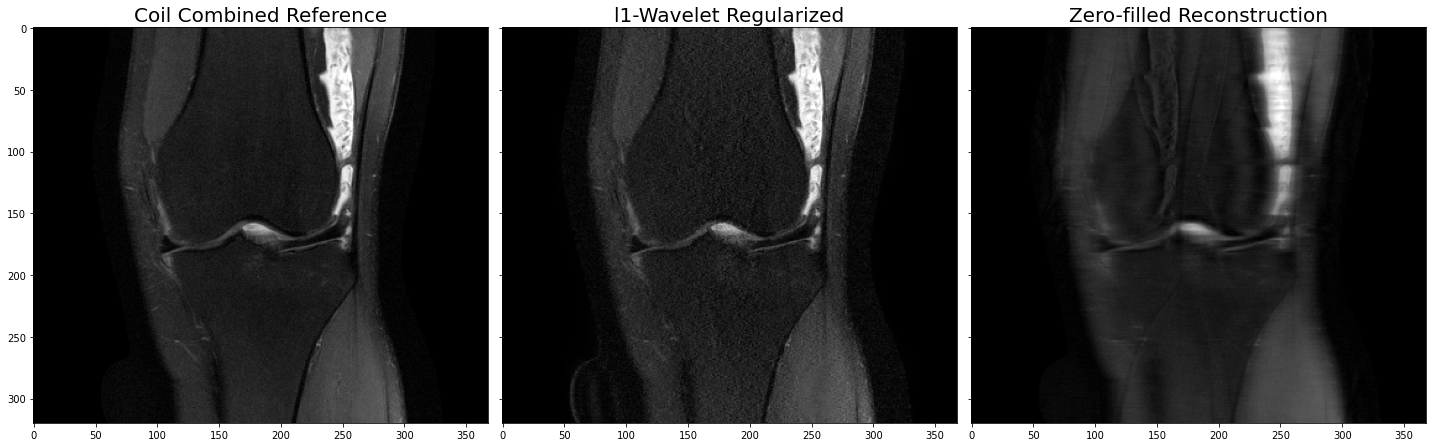

In [21]:
ref = cfl.readcfl("ref")
pics_reco = cfl.readcfl("pics_reco")
zero_filled = cfl.readcfl("zero_filled")

vmax=0.9*np.max(np.abs(ref))

fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=3, sharex=True, sharey=True)

axes[0].imshow(np.abs(ref[::-1,::-1]), cmap="gray", vmax=vmax)
axes[0].set_title("Coil Combined Reference", fontsize=20)

axes[1].imshow(np.abs(pics_reco[::-1,::-1]), cmap="gray", vmax=vmax)
axes[1].set_title("l1-Wavelet Regularized", fontsize=20)

axes[2].imshow(np.abs(zero_filled[::-1,::-1]), cmap="gray", vmax=vmax)
axes[2].set_title("Zero-filled Reconstruction", fontsize=20)

plt.tight_layout()
plt.show()

#### Apply Variational Network

Having prepared the dataset, we can apply the Variational Network using the downloaded weights. The dataset is normalized by the maximum magnitude of the zero-filled reconstruction by using the `--normalize` option.  
We use the pretrained weights provided in the weights directory. They have been trained on the first 15 knees from the coronal_pd_fs directory of the NYU-Dataset

In [23]:
%%bash

[ $CUDA ] && GPU=--gpu; # if BART is compiled with gpu support, we add the --gpu option

bart reconet \
    $GPU \
    --network=varnet \
    --normalize \
    --apply \
    --pattern=data/pattern_po_4 \
    kspace \
    coils \
    data/varnet \
    varnet

Apply RecoNet
NN
inputs: 6
adjoint        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coil           [320 368   1  15   1   1   1   1   1   1   1   1   1   1   1   1 ]
psf            [  1 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
lambda         [ 10 ]
conv           [ 24   1  11  11   1  10 ]
rbf            [ 24  31  10 ]
outputs: 1
INDEX 0        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]


We plot the results:

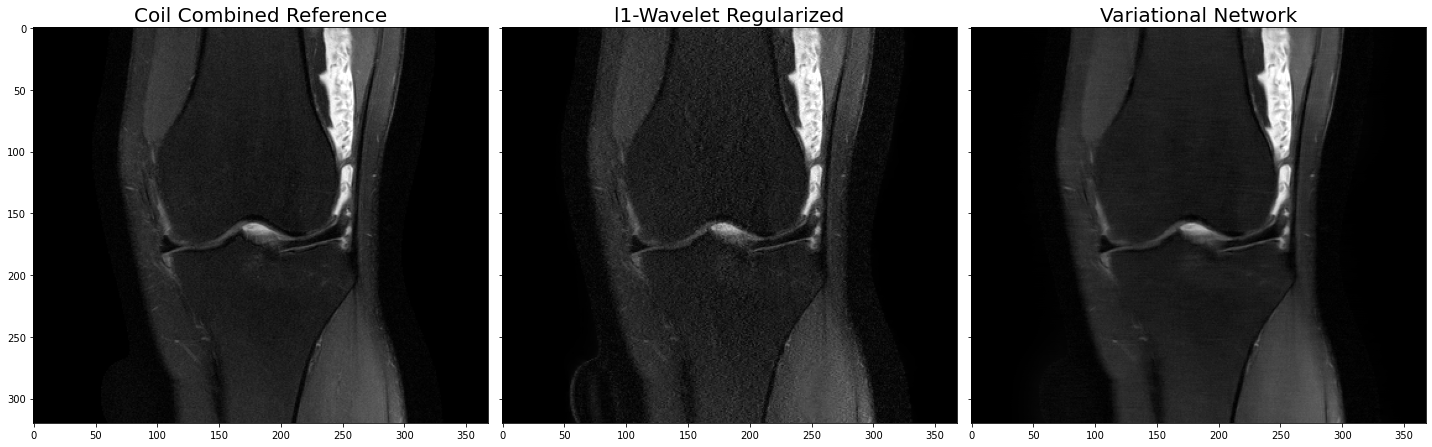

In [24]:
ref = cfl.readcfl("ref")
pics_reco = cfl.readcfl("pics_reco")
varnet = cfl.readcfl("varnet")

vmax=0.9*np.max(np.abs(ref))

fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=3, sharex=True, sharey=True)

axes[0].imshow(np.abs(ref[::-1,::-1]), cmap="gray", vmax=vmax)
axes[0].set_title("Coil Combined Reference", fontsize=20)

axes[1].imshow(np.abs(pics_reco[::-1,::-1]), cmap="gray", vmax=vmax)
axes[1].set_title("l1-Wavelet Regularized", fontsize=20)

axes[2].imshow(np.abs(varnet[::-1,::-1]), cmap="gray", vmax=vmax)
axes[2].set_title("Variational Network", fontsize=20)

plt.tight_layout()
plt.show()

#### Apply MoDL

Similarly, MoDL can be applied using the provided weights. Here, we unroll 5 iterations.

In [25]:
%%bash

[ $CUDA ] && GPU=--gpu; # if BART is compiled with gpu support, we add the --gpu option

bart reconet \
    $GPU \
    --network=modl \
    --iterations=5 \
    --normalize \
    --apply \
    --pattern=data/pattern_po_4 \
    kspace \
    coils \
    data/modl \
    modl

Apply RecoNet
NN
inputs: 14
adjoint        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coil           [320 368   1  15   1   1   1   1   1   1   1   1   1   1   1   1 ]
psf            [  1 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
lambda         [  1 ]
conv_0         [ 32   1   3   3   1   1 ]
conv_i         [ 32  32   3   3   1   3   1 ]
conv_n         [  1  32   3   3   1   1 ]
bias_0         [ 32   1 ]
bias_i         [ 32   3   1 ]
bias_n         [  1   1 ]
gamma          [  1   1   1   1   1   5 ]
bn_0           [ 32   1   1   1   1   2   5 ]
bn_i           [ 32   1   1   1   1   2   3   5 ]
bn_n           [  1   1   1   1   1   2   5 ]
outputs: 4
INDEX 0        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
bn_0           [ 32   1   1   1   1   2   5 ]
bn_i           [ 32   1   1   1   1   2   3   5 ]
bn_n           [  1   1   1   1   1   2   5 ]


We plot the results:

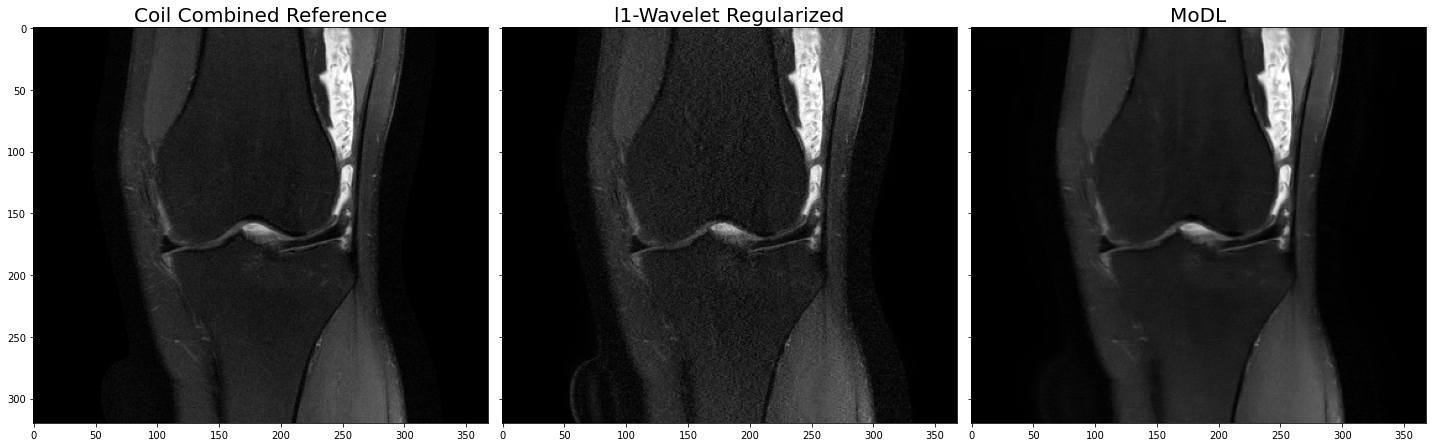

In [26]:
ref = cfl.readcfl("ref")
pics_reco = cfl.readcfl("pics_reco")
modl = cfl.readcfl("modl")

vmax=0.9*np.max(np.abs(ref))

fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=3, sharex=True, sharey=True)

axes[0].imshow(np.abs(ref[::-1,::-1]), cmap="gray", vmax=vmax)
axes[0].set_title("Coil Combined Reference", fontsize=20)

axes[1].imshow(np.abs(pics_reco[::-1,::-1]), cmap="gray", vmax=vmax)
axes[1].set_title("l1-Wavelet Regularized", fontsize=20)

axes[2].imshow(np.abs(modl[::-1,::-1]), cmap="gray", vmax=vmax)
axes[2].set_title("MoDL", fontsize=20)

plt.tight_layout()
plt.show()

#### Evaluation of the Variational Network and MoDL

In [27]:
%%bash

# if BART is compiled with gpu support, we add the --gpu option
[ $CUDA ] && GPU=--gpu;

bart reconet \
    $GPU \
    --network=varnet \
    --normalize \
    --eval \
    --pattern=data/pattern_po_4 \
    kspace \
    coils \
    data/varnet \
    ref 

Apply RecoNet
NN
inputs: 6
adjoint        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coil           [320 368   1  15   1   1   1   1   1   1   1   1   1   1   1   1 ]
psf            [  1 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
lambda         [ 10 ]
conv           [ 24   1  11  11   1  10 ]
rbf            [ 24  31  10 ]
outputs: 1
INDEX 0        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
mse mag: 3.902272e-12
mse: 7.057882e-12
mean psnr: 3.834483e+01
mean ssim: 9.027248e-01
mad: 2.575670e-06
mad mag: 1.365295e-06
nmse: 1.097741e-02
nmse mag: 6.069362e-03


In [28]:
%%bash

# if BART is compiled with gpu support, we add the --gpu option
[ $CUDA ] && GPU=--gpu;

bart reconet \
    $GPU \
    --network=modl \
    --iterations=5 \
    --normalize \
    --eval \
    --pattern=data/pattern_po_4 \
    kspace \
    coils \
    data/modl \
    ref 

Apply RecoNet
NN
inputs: 14
adjoint        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coil           [320 368   1  15   1   1   1   1   1   1   1   1   1   1   1   1 ]
psf            [  1 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
lambda         [  1 ]
conv_0         [ 32   1   3   3   1   1 ]
conv_i         [ 32  32   3   3   1   3   1 ]
conv_n         [  1  32   3   3   1   1 ]
bias_0         [ 32   1 ]
bias_i         [ 32   3   1 ]
bias_n         [  1   1 ]
gamma          [  1   1   1   1   1   5 ]
bn_0           [ 32   1   1   1   1   2   5 ]
bn_i           [ 32   1   1   1   1   2   3   5 ]
bn_n           [  1   1   1   1   1   2   5 ]
outputs: 4
INDEX 0        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
bn_0           [ 32   1   1   1   1   2   5 ]
bn_i           [ 32   1   1   1   1   2   3   5 ]
bn_n           [  1   1   1   1   1   2   5 ]
mse mag: 4.344228e-12
mse: 7.402672e-12
mean psnr: 3.787887e+01
mean ssim